In [1]:
from layout import Layout

## Definition
The (logical) product is defined as $A \otimes B := (A, \tilde A \circ B)$.

In terms of the pseudo code:
```python
size = self.size() * other.cosize()
compl = self.complement(size)
compo = compl.composite(other)
return Layout.from_concate(self, compo)
```

It is best to illustrate the idea of a product using a 2D by-mode operation as follows.

## Example

((2, 3), (5, 4)):((5, 20), (1, 250))

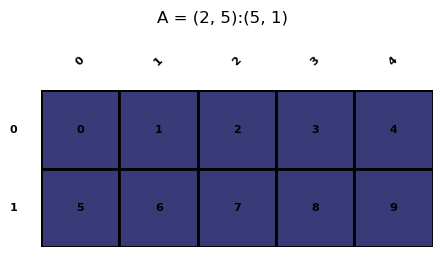

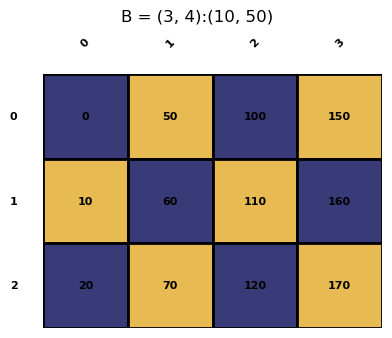

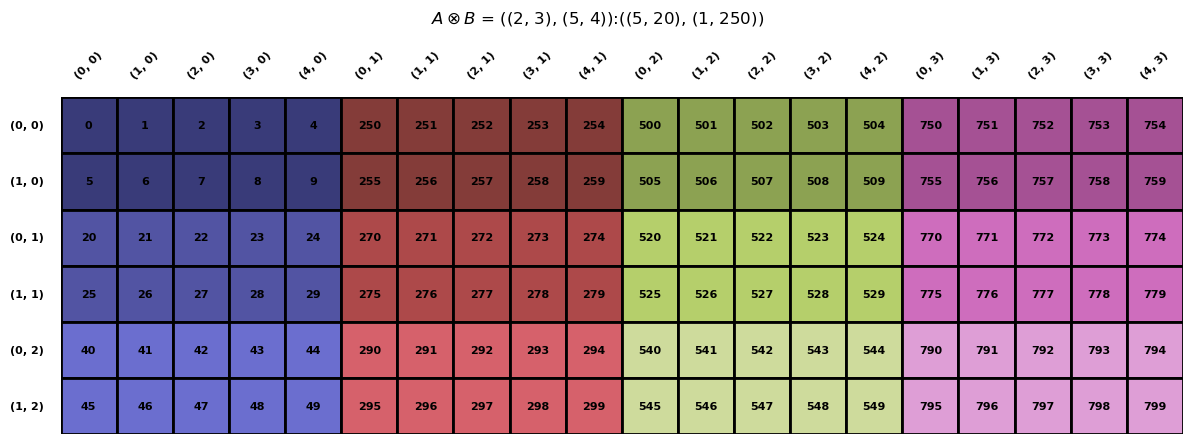

In [2]:
A = Layout.from_string('(2,5):(5,1)').visualize('A', color_cycle=20)
B = Layout.from_string('(3,4):(10,50)').visualize('B')
A.logical_product(B, by_mode=True).visualize('$A \\otimes B$', color_cycle=20)

Let us break down the calculations.

First, look at the 1st mode:

size =  2 * 21 = 42


TypeError: Layout.complement() got an unexpected keyword argument 'color_cycle'

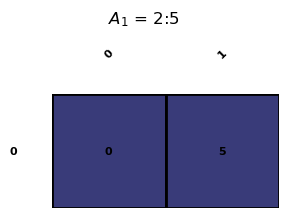

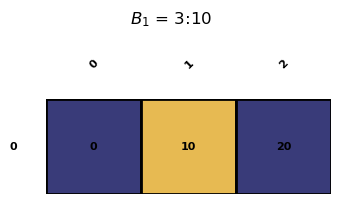

In [3]:
A1 = Layout.from_string('2:5').visualize('$A_1$', color_cycle=20)
B1 = Layout.from_string('3:10').visualize('$B_1$')
print('size = ', A1.size(), '*', B1.cosize(), '=', size:=A1.size() * B1.cosize())
A1.logical_product(B1, visualize_steps=True, color_cycle=20)

## Yet to be Done

In [ ]:
# Layout.from_string('(2,5):(5,1)').visualize().blocked_product(Layout.from_string('(3, 4):(1, 3)').visualize()).visualize()